### Funciones para todos los ejercicios
Adapto las funciones para poder reutilizarlas en los diferentes ejercicios

In [270]:
import random
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("darkgrid")
plt.style.use('dark_background')


# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 7
TASA_MUTACION = 0.1
TASA_CRUCE = 0.92
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = 0
X_MAX = 31
OBJ = 'MAX' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2


#  -----------------------------------------------------------------
# funcion para mapear el valor binario a un rango [X_MIN, X_MAX]
#  -----------------------------------------------------------------
def binario_a_decimal(cromosoma):
    decimal = int(cromosoma, 2)
    x = X_MIN + decimal * (X_MAX - X_MIN) / ((2 ** LONGITUD_CROMOSOMA) - 1)
    return x

#  -----------------------------------------------------------------
# Aqui en las proximas lineas se puede ver que mi funcion objetivo es
# a veces diferente de mi funcion fitness, depende del problema a resolver
#  -----------------------------------------------------------------


#  -----------------------------------------------------------------
# funcion objetivo x^2
#  -----------------------------------------------------------------
def funcion_objetivo(x):
    return x ** 2


#  -----------------------------------------------------------------
# funcion fitness o tambien llamada funcion de aptitud (1/(x^2 + epsilon))
#  -----------------------------------------------------------------
def aptitud(cromosoma):
    x = binario_a_decimal(cromosoma)
    if OBJ == 'MIN':
        return 1 / (funcion_objetivo(x) + EPSILON)
    elif OBJ =='MAX':
        return x ** 2


#  -----------------------------------------------------------------
# se inicializa la poblacion
#  -----------------------------------------------------------------
def inicializar_poblacion(tamanio_poblacion, longitud_cromosoma):
    poblacion = []
    for tp in range(tamanio_poblacion):
        cromosoma = ''
        for lc in range(longitud_cromosoma):
            cromosoma = cromosoma+str(random.randint(0, 1))
        poblacion.append(cromosoma)
    return poblacion

#  -----------------------------------------------------------------
# seleccion por ruleta
#  -----------------------------------------------------------------
def seleccion_ruleta(poblacion, aptitud_total):
    probabilidades = []
    for individuo in poblacion:
        prob = aptitud(individuo) / aptitud_total
        probabilidades.append(prob)

    probabilidades_acumuladas = []
    suma = 0
    for prob in probabilidades:
        suma += prob
        probabilidades_acumuladas.append(suma)

    r = random.random()
    for i, acumulada in enumerate(probabilidades_acumuladas):
        if r <= acumulada:
            return poblacion[i]


#  -----------------------------------------------------------------
# seleccion por torneo
#  -----------------------------------------------------------------
def seleccion_torneo(poblacion, tamanio_torneo=TAMANIO_TORNEO):
    progenitores = []
    for _ in range(len(poblacion)):
        candidatos = random.sample(poblacion, tamanio_torneo)
        progenitor = max(candidatos, key=aptitud)  # se selecciona el mejor individuo del torneo
        progenitores.append(progenitor)
    return progenitores


# -----------------------------------------------------------------
# seleccion por ranking lineal
# -----------------------------------------------------------------
def seleccion_ranking(poblacion):
    # se calcula la aptitud de cada individuo
    aptitudes = []
    for individuo in poblacion:
        aptitudes.append(aptitud(individuo))

    # se ordena la poblacion por aptitud (mayor aptitud es mejor)
    # x es la tupla de zip, de la cual se toma el segundo elemento (x[1]) para
    # ser ordenada la tupla por ese elemento, en este caso por aptitud
    poblacion_ordenada = sorted(zip(poblacion, aptitudes), key=lambda x: x[1])

    # se calcula probabilidades segun el ranking lineal
    N = len(poblacion)
    s = 1.7  # Factor de seleccion comunmente usado
    probabilidades = []
    for i in range(N):
        prob = (2 - s) / N + (2 * i * (s - 1)) / (N * (N - 1))
        probabilidades.append(prob)

    # se selecciona un progenitor basado en las probabilidades
    r = random.random()
    suma = 0
    for i in range(N):
        suma = suma + probabilidades[i]
        if r <= suma:
            return poblacion_ordenada[i][0]  # se retornar el cromosomas

#  -----------------------------------------------------------------
# cruce monopunto con probabilidad de cruza pc = TASA_CRUCE
#  -----------------------------------------------------------------
def cruce_mono_punto(progenitor1, progenitor2, tasa_cruce):
    if random.random() < tasa_cruce:
        punto_cruce = random.randint(1, len(progenitor1) - 1)
        descendiente1 = progenitor1[:punto_cruce] + progenitor2[punto_cruce:]
        descendiente2 = progenitor2[:punto_cruce] + progenitor1[punto_cruce:]
    else:
        descendiente1, descendiente2 = progenitor1, progenitor2
    return descendiente1, descendiente2


#  -----------------------------------------------------------------
# mutacion
#  -----------------------------------------------------------------
def mutacion(cromosoma, tasa_mutacion):
    cromosoma_mutado = ""
    for bit in cromosoma:
        if random.random() < tasa_mutacion:
            cromosoma_mutado = cromosoma_mutado + str(int(not int(bit)))
        else:
            cromosoma_mutado = cromosoma_mutado + bit
    return cromosoma_mutado


In [271]:
#  -----------------------------------------------------------------
# aplicación de operadores geneticos
#  -----------------------------------------------------------------
def algoritmo_genetico(tamanio_poblacion, longitud_cromosoma, tasa_mutacion, tasa_cruce, generaciones, seleccion, elitismo, imprimir=True):
    poblacion = inicializar_poblacion(tamanio_poblacion, longitud_cromosoma)
    mejor_funcion_objetivo_generaciones = []  # Lista para almacenar la aptitud del mejor individuo y grficar luego

    for generacion in range(generaciones):
        if imprimir==True: print("Generación:", generacion + 1)

        # se calcula aptitud total para luego
        aptitud_total = sum(aptitud(cromosoma) for cromosoma in poblacion)

        if imprimir==True: print("Aptitud total:", aptitud_total)

        #  -----------------------------------------------------------------
        
        if seleccion == 'ruleta':
            # seleccion de progenitores con el metodo ruleta
            progenitores = []
            for _ in range(tamanio_poblacion):
                progenitores.append(seleccion_ruleta(poblacion, aptitud_total))
        
        elif seleccion == 'torneo':            
            # seleccion de progenitores con el metodo de torneo
            progenitores = seleccion_torneo(poblacion)
        
        elif seleccion == 'ranking':            
            # seleccion de progenitores con el metodo de ranking lineal
            progenitores = []
            for _ in range(tamanio_poblacion):
                progenitores.append(seleccion_ranking(poblacion))
        #  -----------------------------------------------------------------
        # Cruce
        descendientes = []
        for i in range(0, tamanio_poblacion, 2):
            descendiente1, descendiente2 = cruce_mono_punto(progenitores[i], progenitores[i + 1], tasa_cruce)
            descendientes.extend([descendiente1, descendiente2])

        #  -----------------------------------------------------------------
        # Mutacion
        descendientes_mutados = []
        for descendiente in descendientes:
            descendientes_mutados.append(mutacion(descendiente, tasa_mutacion))

        if elitismo:
            # Aquí se aplica elitismo
            # Se reemplazan los peores cromosomas con los mejores progenitores
            poblacion.sort(key=aptitud)  # se ordena la poblacion por aptitud en forma ascendente
            # se ordena los descendientes por aptitud en forma descendente
            descendientes_mutados.sort(key=aptitud, reverse=True)
            for i in range(len(descendientes_mutados)):
                if aptitud(descendientes_mutados[i]) > aptitud(poblacion[i]):
                    poblacion[i] = descendientes_mutados[i]                

        else: # si no hay elitismo, todos los descendientes pasan a ser la nueva poblacion
            poblacion = descendientes_mutados

        # Mostrar el mejor individuo de la generacion
        mejor_individuo = max(poblacion, key=aptitud)  # Buscar el maximo para la aptitud
        mejor_funcion_objetivo_generaciones.append(funcion_objetivo(binario_a_decimal(mejor_individuo)))

        if imprimir == True:
            print("mi", mejor_individuo)
            print("Mejor individuo:", binario_a_decimal(mejor_individuo), "Aptitud:", aptitud(mejor_individuo))
            print("_________________________________________________________________________________")

    if imprimir ==True:
        # Graficar la evolución de la aptitud
        plt.plot(range(1, generaciones + 1), mejor_funcion_objetivo_generaciones, marker='o')
        plt.xlabel('Generación')
        plt.ylabel('Valor de la Función Objetivo')
        plt.title('Curva de Convergencia del Algoritmo Genético')
        plt.grid(True)
        plt.show()
    return max(poblacion, key=aptitud)  # se retorna el mejor individuo


### Ejercicio 1

_________________________________________________________________________________

Generación: 1
Aptitud total: 1004.1374542749085
mi 1100110
Mejor individuo: 24.89763779527559 Aptitud: 619.8923677847355
_________________________________________________________________________________
Generación: 2
Aptitud total: 1368.4821129642257
mi 1110110
Mejor individuo: 28.80314960629921 Aptitud: 829.6214272428545
_________________________________________________________________________________
Generación: 3
Aptitud total: 2693.5884431768864
mi 1111000
Mejor individuo: 29.291338582677167 Aptitud: 857.982515965032
_________________________________________________________________________________
Generación: 4
Aptitud total: 3027.009982019964
mi 1111100
Mejor individuo: 30.26771653543307 Aptitud: 916.1346642693285
_________________________________________________________________________________
Generación: 5
Aptitud total: 3298.704445408891
mi 1111110
Mejor individuo: 30.755905511811022 Aptitud: 945

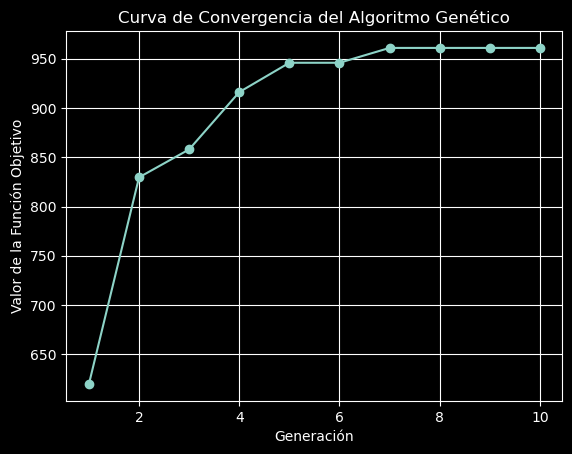

Mejor solución: 31.0 Aptitud: 961.0


In [272]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 7
TASA_MUTACION = 0.1
TASA_CRUCE = 0.92
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = 0
X_MAX = 31
OBJ = 'MAX' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo
TAMANIO_TORNEO = 2

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

In [273]:
# aca voy a generar la tabla con 10 lanzamientos

soluciones = []
for i in range(10):
    soluciones.append(algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA,
                            TASA_MUTACION, TASA_CRUCE, GENERACIONES,SELECCION,
                            ELITISMO, False))
print('Soluciones')
for i, sol in enumerate(soluciones):
    print('{0:.3f}'.format(binario_a_decimal(sol)))

Soluciones
29.047
30.024
31.000
31.000
30.512
31.000
31.000
31.000
31.000
31.000


### Ejercicio 2

#### 2.1_Selecccion Ruleta

_________________________________________________________________________________

Generación: 1
Aptitud total: 0.050653826607474584
mi 0110110000
Mejor individuo: -4.818181818181817 Aptitud: 0.0430739722496824
_________________________________________________________________________________
Generación: 2
Aptitud total: 0.13262476524292352
mi 0110110000
Mejor individuo: -4.818181818181817 Aptitud: 0.0430739722496824
_________________________________________________________________________________
Generación: 3
Aptitud total: 0.13262476524292352
mi 0111100000
Mejor individuo: -1.90909090909091 Aptitud: 0.2743011554652802
_________________________________________________________________________________
Generación: 4
Aptitud total: 0.3804650307027843
mi 0111100000
Mejor individuo: -1.90909090909091 Aptitud: 0.2743011554652802
_________________________________________________________________________________
Generación: 5
Aptitud total: 0.8761550683815338
mi 0111110100
Mejor individuo: -0.6

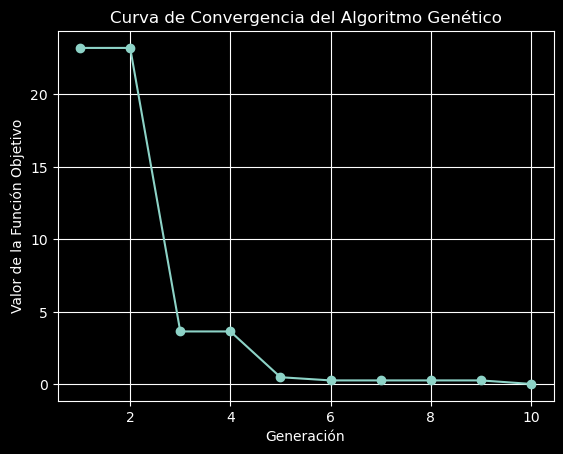

Mejor solución: -0.15151515151515227 Aptitud: 41.7417302311315


In [276]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ruleta' # ruleta, ranking o torneo


#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

In [277]:
# aca voy a generar la tabla con 10 lanzamientos

solucionesRuleta = []
for i in range(30):
    solucionesRuleta.append(algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA,
                            TASA_MUTACION, TASA_CRUCE, GENERACIONES,SELECCION,
                            ELITISMO, False))
print('SolucionesRuleta')
for i, sol in enumerate(solucionesRuleta):
    print('{0:.3f}'.format(binario_a_decimal(sol)))

SolucionesRuleta
-0.030
0.515
0.030
-0.030
1.000
-0.091
0.030
1.000
-0.030
0.091
-0.212
-0.030
-0.273
-0.515
-0.394
0.030
-0.030
0.152
-0.030
0.030
-0.030
1.000
-0.030
-0.030
-0.455
0.030
-3.909
0.030
4.273
0.030


#### 2.2_Seleccion Torneo

_________________________________________________________________________________

Generación: 1
Aptitud total: 0.037156032043231195
mi 0111100110
Mejor individuo: -1.5454545454545467 Aptitud: 0.41850989724025517
_________________________________________________________________________________
Generación: 2
Aptitud total: 0.45915796673756537
mi 0111110110
Mejor individuo: -0.5757575757575744 Aptitud: 3.0075478680656005
_________________________________________________________________________________
Generación: 3
Aptitud total: 4.732757671591129
mi 0111110111
Mejor individuo: -0.5151515151515156 Aptitud: 3.7540203179024307
_________________________________________________________________________________
Generación: 4
Aptitud total: 9.018081575756412
mi 0111110111
Mejor individuo: -0.5151515151515156 Aptitud: 3.7540203179024307
_________________________________________________________________________________
Generación: 5
Aptitud total: 8.127349278273684
mi 0111011111
Mejor individuo: -

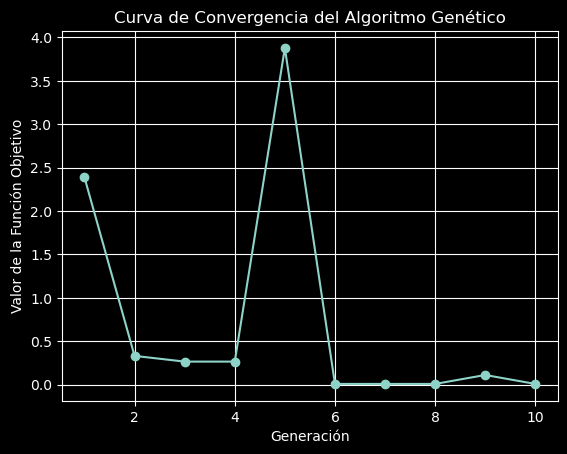

Mejor solución: -0.09090909090908994 Aptitud: 107.93933987511356


In [289]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = False # True o False
SELECCION = 'torneo' # ruleta, ranking o torneo

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

In [290]:
# aca voy a generar la tabla con 10 lanzamientos

solucionesTorneo = []
for i in range(30):
    solucionesTorneo.append(algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA,
                            TASA_MUTACION, TASA_CRUCE, GENERACIONES,SELECCION,
                            ELITISMO, False))
print('solucionesTorneo')
for i, sol in enumerate(solucionesTorneo):
    print('{0:.3f}'.format(binario_a_decimal(sol)))

solucionesTorneo
2.030
1.606
3.061
0.273
-4.636
9.909
0.636
0.636
-1.182
-3.667
-0.212
-29.545
0.515
-1.364
-0.273
0.455
-0.636
-3.061
-0.091
0.030
0.091
1.061
0.515
-0.818
-3.000
0.273
-4.394
0.273
3.182
0.455


#### 2.3_Seleccion Ranking

_________________________________________________________________________________

Generación: 1
Aptitud total: 0.037462896873731125
mi 0110011011
Mejor individuo: -6.09090909090909 Aptitud: 0.026954051806578623
_________________________________________________________________________________
Generación: 2
Aptitud total: 0.05610480599405418
mi 0110011011
Mejor individuo: -6.09090909090909 Aptitud: 0.026954051806578623
_________________________________________________________________________________
Generación: 3
Aptitud total: 0.0683036891378322
mi 0110011011
Mejor individuo: -6.09090909090909 Aptitud: 0.026954051806578623
_________________________________________________________________________________
Generación: 4
Aptitud total: 0.09437476022542526
mi 0110011011
Mejor individuo: -6.09090909090909 Aptitud: 0.026954051806578623
_________________________________________________________________________________
Generación: 5
Aptitud total: 0.09472359717451315
mi 0110011011
Mejor individu

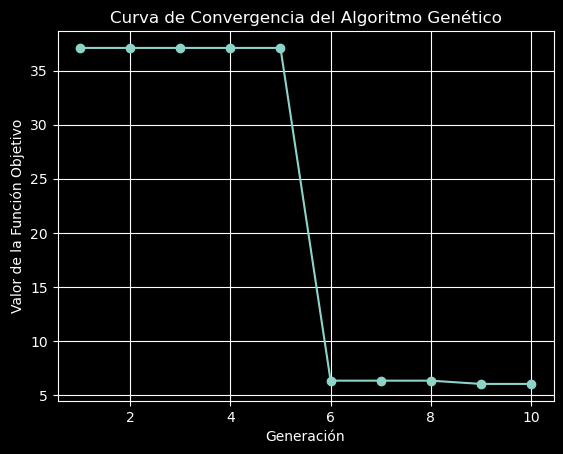

Mejor solución: -2.4545454545454533 Aptitud: 0.16595325055786367


In [291]:
# parametros
TAMANIO_POBLACION = 4
LONGITUD_CROMOSOMA = 10
TASA_MUTACION = 0.09
TASA_CRUCE = 0.85
GENERACIONES = 10
EPSILON = 0.001  # Valor pequeño para evitar división por cero en la funcion fitness
X_MIN = -31
X_MAX = 31
OBJ = 'MIN' # MAX o MIN
ELITISMO = True # True o False
SELECCION = 'ranking' # ruleta, ranking o torneo

#  -----------------------------------------------------------------
# ejecucion principal del algoritmo genetico
#  -----------------------------------------------------------------
print("_________________________________________________________________________________")
print()
mejor_solucion = algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA, TASA_MUTACION, TASA_CRUCE, GENERACIONES, SELECCION, ELITISMO)
print("Mejor solución:", binario_a_decimal(mejor_solucion), "Aptitud:", aptitud(mejor_solucion))

In [296]:
# aca voy a generar la tabla con 10 lanzamientos

solucionesRanking = []
for i in range(30):
    solucionesRanking.append(algoritmo_genetico(TAMANIO_POBLACION, LONGITUD_CROMOSOMA,
                            TASA_MUTACION, TASA_CRUCE, GENERACIONES,SELECCION,
                            ELITISMO, False))
print('solucionesRanking')
for i, sol in enumerate(solucionesRanking):
    print('{0:.3f}'.format(binario_a_decimal(sol)))

solucionesRanking
2.030
-1.970
0.212
0.273
-0.273
-0.030
-1.000
-0.091
0.030
-1.242
-1.970
0.091
0.394
-1.000
0.030
0.152
-0.515
0.152
0.030
-1.970
0.030
0.030
0.030
0.030
-0.152
-0.030
-0.030
0.030
-0.394
0.030


In [304]:
import numpy as np
rank = np.array([binario_a_decimal(i) for i in solucionesRanking])
rule = np.array([binario_a_decimal(i) for i in solucionesRuleta])
torn = np.array([binario_a_decimal(i) for i in solucionesTorneo])

In [327]:
tabla = np.array(
    [[rank.min(), rank.mean(), rank.max(), rank.std()],
    [rule.min(), rule.mean(), rule.max(), rule.std()],
    [torn.min(), torn.mean(), torn.max(), torn.std()]])

print(tabla)

[[ -1.97   -0.236   2.03    0.785]
 [ -3.909   0.071   4.273   1.117]
 [-29.545  -0.929   9.909   5.921]]
